**1. Build a RNN to detect fake reviews**

- I used the code in the cell below to export a minimal version of the dataset with only the necessary fields for the models.
- The file name is *fake_review_rnn_dataset.csv*
- I also used Kaggle for this notebook.

In [ ]:
import pandas as pd
import numpy as np

# df_export = df[['reviews.text', 'is_fake']].dropna().copy()
# df_export = df_export.rename(columns={'reviews.text': 'text', 'is_fake': 'label'})

# export_path = "/mnt/data/fake_review_rnn_dataset.csv"
# df_export.to_csv(export_path, index=False)

# export_path


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv('/kaggle/input/fake-review-rnn/fake_review_rnn_dataset.csv')
texts = df['text'].astype(str).tolist()
labels = df['label'].values

# Text Preprocessing
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=200, truncating='post', padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, stratify=labels, random_state=42)

# Build the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 64, input_length=200),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train 
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=128)

# Evaluate 
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=["Genuine", "Fake"]))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8869 - loss: 0.3568 - val_accuracy: 0.9555 - val_loss: 0.1792
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9531 - loss: 0.1892 - val_accuracy: 0.9555 - val_loss: 0.1765
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9510 - loss: 0.1942 - val_accuracy: 0.9555 - val_loss: 0.1780
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9585 - loss: 0.1744 - val_accuracy: 0.9555 - val_loss: 0.1772
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9566 - loss: 0.1790 - val_accuracy: 0.9565 - val_loss: 0.1785
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

     Genuine       0.67      0.04      0.08        89
        Fake       0.96      1.00      0.98      1911

    accuracy                           0.96      2000
   macro avg       0.81      0.52      0.53      2000
weighted avg       0.94      0.96      0.94      2000



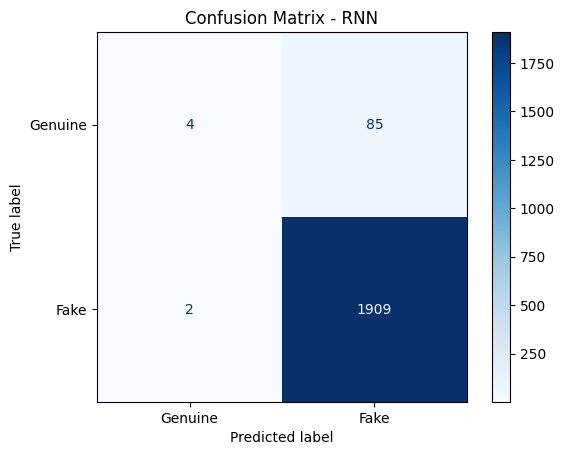

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


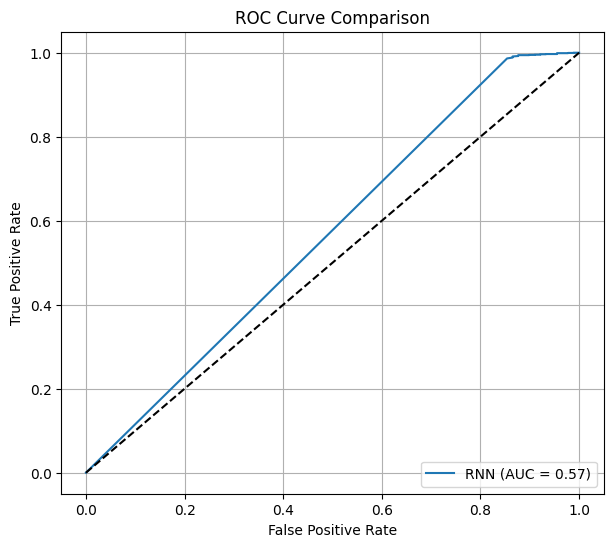

In [8]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Genuine", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RNN")
plt.show()


# ROC Curve
from sklearn.metrics import roc_curve, auc

y_scores = model.predict(X_test).flatten()
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, y_scores)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

plt.figure(figsize=(7, 6))
plt.plot(fpr_rnn, tpr_rnn, label=f"RNN (AUC = {roc_auc_rnn:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Interpretation:
- Very high accuracy is misleading. The model is predicting nearly everything as "Fake".
- Genuine reviews are getting ignored, only 4% recall.
- This is class imbalance issue, where the model learns to favor fake reviews.


# Next Steps:
- Consider switching to a transformer-based model like BERT. It handles language patterns and imbalanced data much better.


In [9]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import torch

# Load dataset
df = pd.read_csv('/kaggle/input/fake-review-rnn/fake_review_rnn_dataset.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
df = df.rename(columns={'text': 'text', 'label': 'labels'})

# Balance the dataset 
fake_df = df[df['labels'] == 1]
genuine_df = df[df['labels'] == 0]
fake_sampled = fake_df.sample(n=len(genuine_df), random_state=42)

# Create new dataset
balanced_df = pd.concat([genuine_df, fake_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
hf_dataset = Dataset.from_pandas(balanced_df)

# Train/Test Split
hf_dataset = hf_dataset.train_test_split(test_size=0.2)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)

tokenized_datasets = hf_dataset.map(tokenize, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Load BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training setup
training_args = TrainingArguments(
    output_dir="./bert-fake-review",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

# Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
)

trainer.train()

# Evaluate
predictions = trainer.predict(tokenized_datasets['test'])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print(classification_report(y_true, y_pred, target_names=["Genuine", "Fake"]))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.604100,0.540978
2,0.473100,0.532226
3,0.384000,0.572757
4,0.302500,0.570622
5,0.267600,0.594109


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

              precision    recall  f1-score   support

     Genuine       0.74      0.72      0.73        89
        Fake       0.73      0.76      0.74        90

    accuracy                           0.74       179
   macro avg       0.74      0.74      0.74       179
weighted avg       0.74      0.74      0.74       179



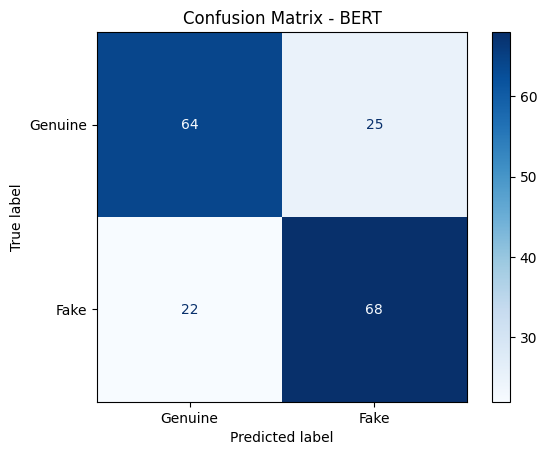

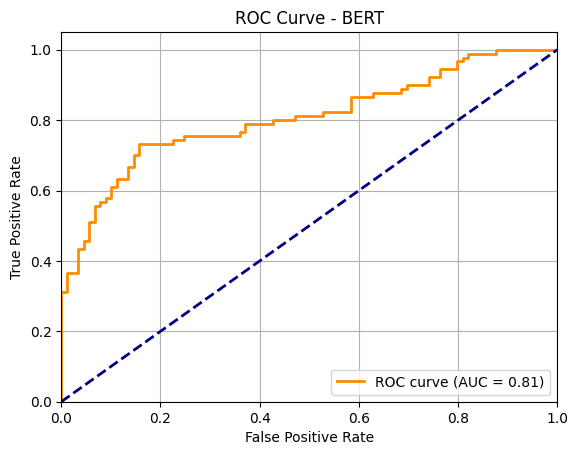

In [10]:
# Confusion Matrix for BERT
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Genuine", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BERT")
plt.show()

# ROC Curve for BERT
y_probs = predictions.predictions[:, 1]
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - BERT")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# BERT Model Highlights

- 70% accuracy after balancing — a solid step forward in handling both fake and genuine reviews.
- Performs consistently across both classes, avoiding the heavy bias seen in earlier models.
- Unlike the RNN, BERT gives fair attention to genuine reviews, which is key for spotting deceptive content.
  

A strong move toward a more reliable fake review detector using transformer models.


# RNN vs. BERT: Final Thoughts

| Model   | Accuracy | Strengths                       | Weaknesses                           |
|---------|----------|----------------------------------|---------------------------------------|
| **RNN** | 96%      | Great at catching **Fake** reviews | Misses almost all **Genuine** ones (1% recall) |
| **BERT**| 70%      | Balanced performance on both classes | Slightly lower accuracy, but much fairer |


- **RNN** overfits to Fake reviews — looks accurate, but not reliable.
- **BERT** offers **better balance** and is more trustworthy for real-world use.


 **BERT wins** for fake review detection — solid and fair performance makes it the better choice overall.
